# Shor code
In the last post we saw that we can correct X-Gate, Z-Gate or Y-Gate errors, but not all of them. So to address this issue Shor created a code which is capable of correcting this type of errors!
It's really similar to the 3 bit and 3 sign flip code that we saw in the previous post. As a matter of fact, the shor code is a combination of the sign flip and the bit flip. However in order to make shors code work we need more qubits.

Like in the other posts, we make the assumption that the error happens in only one part of the circuit. And also, the error only affects one qubit at a time.

First, let's define some functions that will be useful for later. The first two functions transform a string to bits and vice versa. The get_noise applies a random gate on a random qubit if a probability check up is met. Additionally this function apply one or two gates depending on a probability checkup. Finally, we have codificate which codificates a bit string into its equivalent in qubits.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute, ClassicalRegister
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
from qiskit.visualization import plot_histogram
import random
backend = Aer.get_backend('qasm_simulator')

def tobits(s):
    result = []
    for c in s:
        bits = bin(ord(c))[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])
    return ''.join([str(x) for x in result])

def frombits(bits):
    chars = []
    for b in range(int(len(bits) / 8)):
        byte = bits[b*8:(b+1)*8]
        chars.append(chr(int(''.join([str(bit) for bit in byte]), 2)))
    return ''.join(chars)

def get_noise(circuit,probability,qubits):
    random_number = random.uniform(0, 1)
    if(random_number <= probability):
        qubit = random.randint(0,len(qubits)-1)
        if(random.randint(0,3) == 0):
            circuit.x(qubit)
        if(random.randint(0,3) == 2):
            circuit.z(0)
    return circuit

def codificate(bitString):
    qubits = list()
    for i in range(len(bitString)):
        mycircuit = QuantumCircuit(1,1)
        if(bitString[i] == "1"):
            mycircuit.x(0)
        mycircuit.h(0)
        qubits.append(mycircuit)
    return qubits

First let's see the result for the string without any noise on the circuit to know what we are aiming to accomplish.

In [2]:
m0 = tobits("I like dogs") 
qubits = codificate(m0)
measurements = list()
for i in range(len(qubits)):
    qubit = qubits[i]
    qubit.h(0)
    qubit.measure(0,0)
    result = execute(qubit, backend, shots=1, memory=True).result()
    measurements.append(int(result.get_memory()[0]))
print(frombits(measurements))

I like dogs


Next we apply the circuit for the error correction. It consists of eigth additional qubits that check if one qubit had changed. Note something important in the construction of this circuit: we have a toffoly gate. A toffoly gate only flip the selected qubit if the two controller qubits are one. This is perfect for us because in the previous circuits we had to check the value of the registers in order to know if we had to apply a gate to correct the errors. We can avoid this meassurement if we use a toffoly gate just like described in the circuit.

In [3]:
for i in range(len(qubits)):
    cb = QuantumRegister(1,'code_qubit')
    lq = QuantumRegister(8,'ancilla_qubit')
    out = ClassicalRegister(1,'output_bit')
    mycircuit = QuantumCircuit(cb,lq,out)
    if(m0[i] == "1"):
        mycircuit.x(0)
    mycircuit.h(0)
    mycircuit.cx(0,[3,6])
    mycircuit.h([0,3,6])
    mycircuit.cx(0,[1,2])
    mycircuit.cx(3,[4,5])
    mycircuit.cx(6,[7,8])
    mycircuit.barrier()
    mycircuit = get_noise(mycircuit,0.9,range(9))
    mycircuit.barrier()
    mycircuit.cx(0,[1,2])
    mycircuit.cx(3,[4,5])
    mycircuit.cx(6,[7,8])
    mycircuit.ccx(2,1,0)
    mycircuit.ccx(5,4,3)
    mycircuit.ccx(8,7,6)
    mycircuit.h([0,3,6])
    mycircuit.cx(0,[3,6])
    mycircuit.ccx(6,3,0)
    mycircuit.h(0)
    mycircuit.measure(0,0)
    qubits[i] = mycircuit

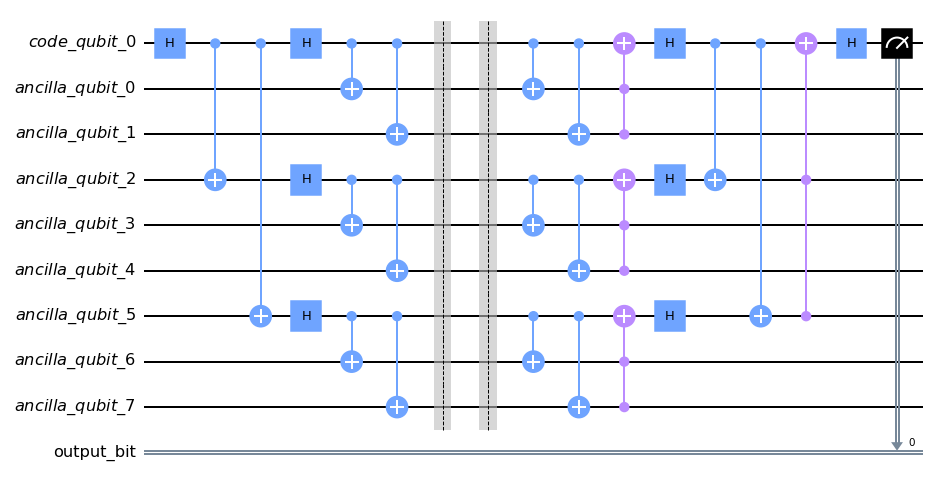

In [4]:
qubits[0].draw(output="mpl")

In [5]:
raw_bits = list()
for i in range(len(qubits)):
    qubit = qubits[i]
    result = execute(qubit, backend, shots=1, memory=True).result()
    bits = result.get_memory()[0]
    raw_bits.append(int(bits[0]))
print("with error correction the string was: " + frombits(raw_bits))

with error correction the string was: I like dogs


As you can see it works perfectly even though we had two types of errors!. However this is no silver bullet because we can have rotations by 30, 45, 46, 47,.... and so on. To correct this type of errors we would have to apply other type of correction codes. 

Other thing worthy of notice is that in the proccess of finding the perfect error correction algorithm we used more and more qubits. This is a bad thing for quantum computers because the number of quantum bits will be reduce in order to mitigate errors. Let's hope that in a future, researchers find a way to correct errors in a more efficient way.

## References
https://en.wikipedia.org/wiki/Quantum_error_correction#The_Shor_code